# Importing libraries

In [19]:
import zipfile
import re
from collections import defaultdict
import scipy.io
import tempfile
import shutil
import matplotlib.pyplot as plt
import os


# nuovi
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np


#!pip install scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM,Input, GlobalAveragePooling1D, PReLU, Softmax, Maximum, GlobalMaxPooling1D
from sklearn.utils import compute_class_weight
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

from scipy.signal import butter, lfilter, filtfilt
from keras.utils import pad_sequences
from keras.metrics import F1Score, Precision, Recall, BinaryAccuracy, Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical

from scipy.signal import cheby2, lfilter

# Data extraction

I extract the data from the zip file and create a list to hold all the data (each entry is a dictionary):

- labels: Labels for each beat
- speaks: Systolic peak location
- ppg: PPG signal

## Data recorded at 128 Hz

In [20]:
mat_files_dir = '/kaggle/input/train-20240708t093209z-001/train'
mat_file_groups = defaultdict(dict)

pattern = re.compile(r'(S\d+_128)(_ann\.mat|\.mat|_spk\.mat)')

all_files = os.listdir(mat_files_dir)

for file in all_files:
    match = pattern.match(file)
    if match:
        base_name = match.group(1)
        suffix = match.group(2)
        file_path = os.path.join(mat_files_dir, file)
        mat_file_groups[base_name][suffix] = file_path

final_groups = []
for base_name, files in mat_file_groups.items():
    if len(files) == 3:  
        final_groups.append((files['_ann.mat'], files['.mat'], files['_spk.mat']))

data_list_128 = []

for group in final_groups:
    ann_data = scipy.io.loadmat(group[0])
    mat_data = scipy.io.loadmat(group[1])
    spk_data = scipy.io.loadmat(group[2])

    labels = ann_data.get('labels')
    speaks = spk_data.get('speaks')
    ppg = mat_data.get('ppg')

    data_dict = {
        'labels': labels,
        'speaks': speaks,
        'ppg': ppg
    }

    data_list_128.append(data_dict)

## Data recorded at 250 Hz

In [21]:
mat_files_dir = '/kaggle/input/train-20240708t093209z-001/train'
mat_file_groups = defaultdict(dict)

pattern = re.compile(r'(S\d+_250)(_ann\.mat|\.mat|_spk\.mat)')

all_files = os.listdir(mat_files_dir)

for file in all_files:
    match = pattern.match(file)
    if match:
        base_name = match.group(1)
        suffix = match.group(2)
        file_path = os.path.join(mat_files_dir, file)
        mat_file_groups[base_name][suffix] = file_path

final_groups = []
for base_name, files in mat_file_groups.items():
    if len(files) == 3:  
        final_groups.append((files['_ann.mat'], files['.mat'], files['_spk.mat']))

data_list_250 = []

for group in final_groups:
    ann_data = scipy.io.loadmat(group[0])
    mat_data = scipy.io.loadmat(group[1])
    spk_data = scipy.io.loadmat(group[2])

    labels = ann_data.get('labels')
    speaks = spk_data.get('speaks')
    ppg = mat_data.get('ppg')

    data_dict = {
        'labels': labels,
        'speaks': speaks,
        'ppg': ppg
    }
    data_list_250.append(data_dict)

In [22]:
data_list = data_list_128 + data_list_250

print(len(data_list_128), len(data_list_250), len(data_list))

speaks = []
for data in data_list:
    speaks.append(data['speaks'])

labels = []
for data in data_list:
    labels.append(data['labels'])

62 43 105


## Plot of one signal for each sampling frequency

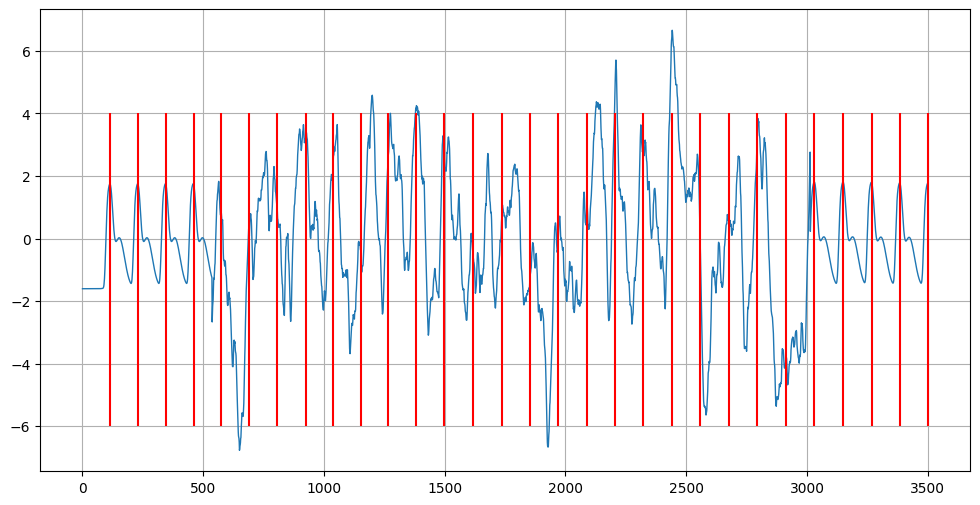

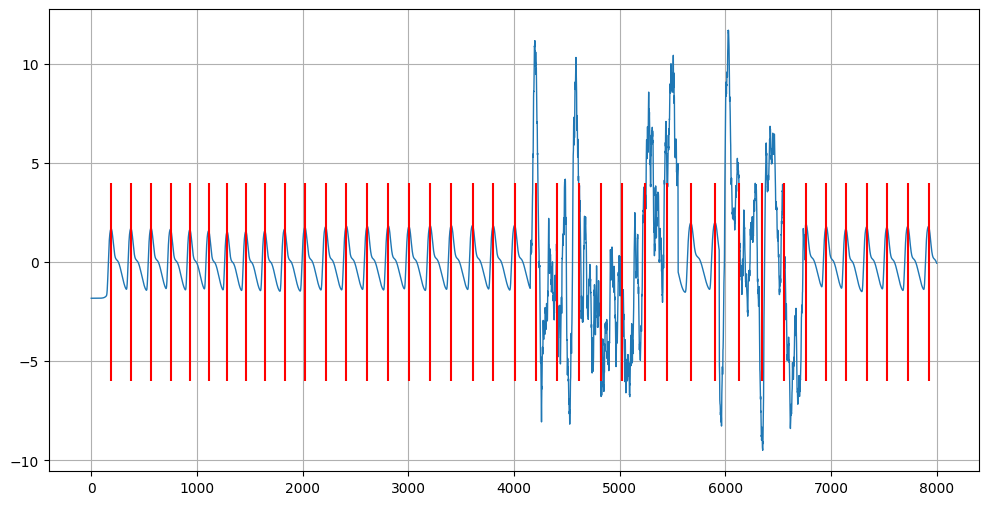

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data_list_128[0]['ppg'][:3500], linewidth = 1)
plt.vlines(np.array(data_list_128[0]['speaks'][:30]), ymin= -6, ymax= 4, color = 'red')
plt.grid(True)

plt.figure(figsize=(12,6))
plt.plot(data_list_250[0]['ppg'][:8000], linewidth = 1)
plt.vlines(np.array(data_list_250[0]['speaks'][:40]), ymin= -6, ymax= 4, color = 'red')
plt.grid(True)

# Data exploration

## Labels distribution

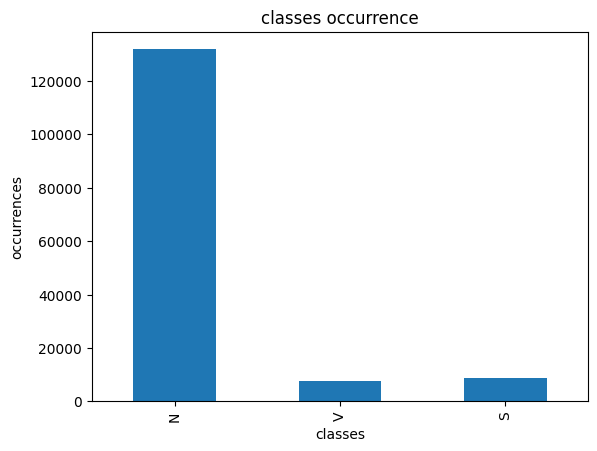

0.8892 0.0513 0.0595


In [24]:
# 128

labels_counter_128 = list()
for data in data_list_128:
    for beat in data['labels']:
        labels_counter_128.append(beat)
label_counts = Counter(labels_counter_128)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, title='classes occurrence', xlabel='classes', ylabel='occurrences')
plt.savefig('labels_distribution_128.png')
plt.show()
# labels' frequencies
l_128 = np.array(labels_counter_128)
n_128 = len(np.argwhere(l_128 == 'N'))
v_128 = len(np.argwhere(l_128 == 'V'))
s_128 = len(np.argwhere(l_128 == 'S'))

fn = n_128/len(l_128)
fv = v_128/len(l_128)
fs = s_128/len(l_128)

print(round(fn, 4), round(fv, 4), round(fs, 4))

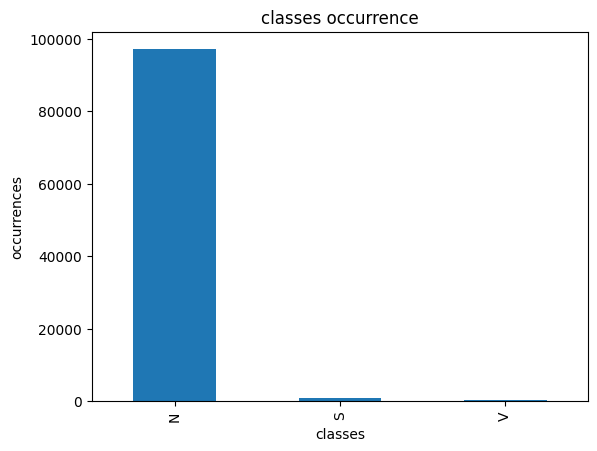

0.9873 0.004 0.0088


In [25]:
# 250

labels_counter_250 = list()
for data in data_list_250:
    for beat in data['labels']:
        labels_counter_250.append(beat)
label_counts = Counter(labels_counter_250)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, title='classes occurrence', xlabel='classes', ylabel='occurrences')
plt.savefig('labels_distribution_250.png')
plt.show()
l_250 = np.array(labels_counter_250)
n_250 = len(np.argwhere(l_250 == 'N'))
v_250 = len(np.argwhere(l_250 == 'V'))
s_250 = len(np.argwhere(l_250 == 'S'))

fn = n_250/len(l_250)
fv = v_250/len(l_250)
fs = s_250/len(l_250)

print(round(fn, 4), round(fv, 4), round(fs, 4))

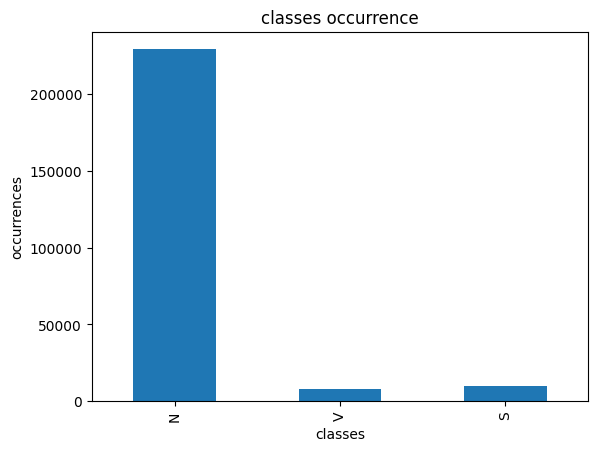

0.9283 0.0324 0.0393


In [26]:
# Combined

labels_counter = list()
for data in data_list:
    for beat in data['labels']:
        labels_counter.append(beat)
label_counts = Counter(labels_counter)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, title='classes occurrence', xlabel='classes', ylabel='occurrences')
plt.savefig('labels_distribution.png')
plt.show()

l = np.array(labels_counter)
n = len(np.argwhere(l == 'N'))
v = len(np.argwhere(l == 'V'))
s = len(np.argwhere(l == 'S'))

fn = n/len(l)
fv = v/len(l)
fs = s/len(l)

print(round(fn, 4), round(fv, 4), round(fs, 4))

# Preprocessing

## Passband filter

In [27]:
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order=4, stopband_atten=40):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    # b, a = butter(filter_order, [low, high], btype="band")
    b, a = cheby2(filter_order, stopband_atten, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y


In [28]:
filtered_128 = []
for data in data_list_128:
    y = bandpass_filter(data['ppg'], 0.5, 5, 128, 4)
    filtered_128.append(y)

filtered_250 = []
for data in data_list_250:
    y = bandpass_filter(data['ppg'], 0.5, 5, 250, 4)
    filtered_250.append(y)

filtered = filtered_128 + filtered_250

#filtered = filtered_128
#data_list = data_list_128

#filtered = filtered_250
#data_list = data_list_250

print(len(filtered_128), len(filtered_250), len(filtered))



62 43 105


## Window size

In [29]:
flat_speaks = [item[0] for sublist in speaks for item in sublist]

diff_speaks = np.diff(flat_speaks)
window_size = np.quantile(diff_speaks, 0.99)
print(window_size)

270.0


## Train-test setup

In [30]:
window_size = 270
#window_size = 162 for 128 Hz data
#window_size = 286 for 250 Hz data
segments_N = []
labels_N = []

segments_SV = []
labels_SV = []

# I create the lists for both the types of beat
for i,data in enumerate(filtered):
    data = np.array(data)
    for j,idx in enumerate(speaks[i]):
        centro = idx[0]
        start = max(0, centro - window_size // 2)
        end = min(data.shape[0], centro + window_size // 2)
        if end - start == window_size:
            if labels[i][j] == 'N':
                segments_N.append(data[start:end])
                labels_N.append(labels[i][j])
            else:
                segments_SV.append(data[start:end])
                labels_SV.append(labels[i][j])
        

segments_N = np.array(segments_N)
labels_N = np.array(labels_N)
segments_SV = np.array(segments_SV)
labels_SV = np.array(labels_SV)

segments_N = np.squeeze(segments_N)
segments_SV = np.squeeze(segments_SV)

# stacking the two groups

segments_NSV = np.vstack((segments_N, segments_SV))
print(segments_NSV.shape)
labels_NSV = np.hstack((labels_N, labels_SV))
print(labels_NSV.shape)

# mapping labels

def map_labels(label):
    if label == 'N':
        return 0
    else:
        return 1

labels_mapped = np.array([map_labels(label) for label in labels_NSV])

# standardize and train-test split
scaler = StandardScaler()
segments_scaled = scaler.fit_transform(segments_NSV)
X_train, X_test, y_train, y_test = train_test_split(segments_scaled, labels_mapped, test_size=0.2, random_state=42)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# reshaping for network input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0],1))
y_train = y_train.reshape((y_train.shape[0],1))


(246518, 270)
(246518,)


### (Undersampling)

In [316]:
#sv = np.argwhere(y_train == 1)
#l_sv = len(sv)
#n = np.argwhere(y_train == 0)
#xx = np.vstack((X_train[n[:l_sv,0],:].squeeze(), X_train[sv.squeeze(),:]))
#y1 = y_train[n[:l_sv]].squeeze()
#y2 = y_train[sv.squeeze()]
#yy = np.concatenate((y1, y2))
#X_train = xx
#y_train = yy
#np.random.seed(42)
#shuffle_index = np.random.permutation(len(y_train))
#X_train = X_train[shuffle_index]
#y_train = y_train[shuffle_index]

Let's check that both train and test labels are equally unbalanced

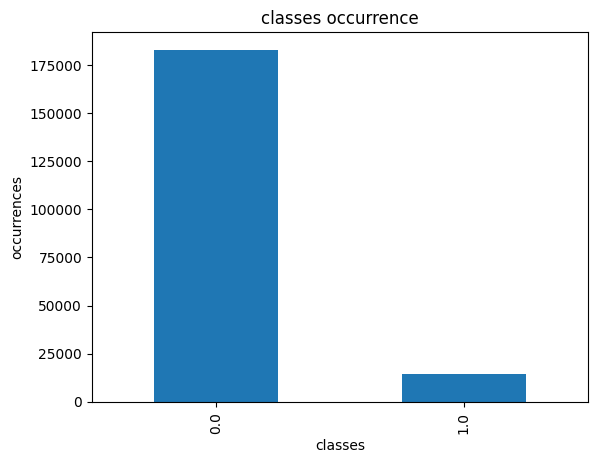

In [32]:
labels_counter = list()
for data in y_train.squeeze():
    labels_counter.append(data)
label_counts = Counter(labels_counter)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, title='classes occurrence', xlabel='classes', ylabel='occurrences')
plt.show()

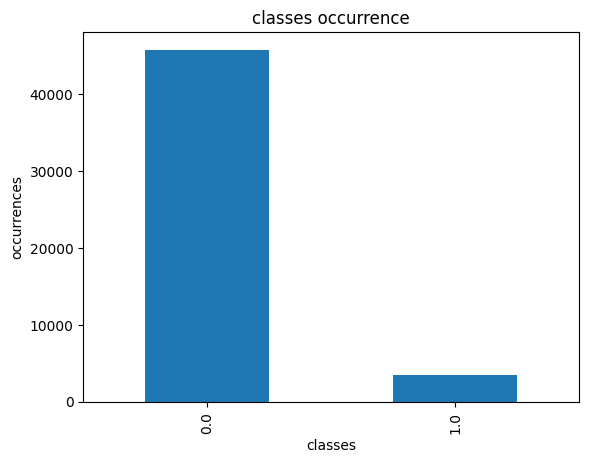

In [33]:
labels_counter = list()
for data in y_test.squeeze():
    labels_counter.append(data)
label_counts = Counter(labels_counter)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar', legend=False, title='classes occurrence', xlabel='classes', ylabel='occurrences')
plt.show()

# 1. NN with 2 hidden layers

## Complete dataset

In [20]:
model_1 = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

# Compilazione del modello
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5),'precision', 'recall'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_1.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

# Valutazione del modello
loss, f1score, precision, recall = model_1.evaluate(X_test, y_test)

Epoch 1/40
  85/6163 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - f1_score: 0.0667 - loss: 0.5141 - precision: 0.0637 - recall: 0.1404

I0000 00:00:1721376067.856576     174 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.2840 - loss: 0.2225 - precision: 0.5628 - recall: 0.1966 - val_f1_score: 0.6046 - val_loss: 0.1514 - val_precision: 0.7642 - val_recall: 0.5001
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5891 - loss: 0.1484 - precision: 0.7841 - recall: 0.4719 - val_f1_score: 0.6084 - val_loss: 0.1425 - val_precision: 0.8353 - val_recall: 0.4784
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.6086 - loss: 0.1408 - precision: 0.8066 - recall: 0.4887 - val_f1_score: 0.5913 - val_loss: 0.1384 - val_precision: 0.8902 - val_recall: 0.4427
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.6206 - loss: 0.1362 - precision: 0.8204 - recall: 0.4992 - val_f1_score: 0.6264 - val_loss: 0.1393 - val_precision: 0.7845 - val_recall: 0.5213
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.6147 - loss: 0.1357 - precision: 0.8191 - recall: 0.4919 - val_f1_score: 0.6276 - val_loss

In [ ]:
plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('epoch')
plt.ylabel('f1score')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

## Only 128

In [26]:
model_1_128 = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

# Compilazione del modello
model_1_128.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5),'precision', 'recall'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_1_128.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

# Valutazione del modello
loss, f1score, precision, recall = model_1_128.evaluate(X_test, y_test)

Epoch 1/40
3707/3707 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - f1_score: 0.3032 - loss: 0.3010 - precision: 0.5967 - recall: 0.2125 - val_f1_score: 0.5966 - val_loss: 0.2117 - val_precision: 0.8025 - val_recall: 0.4747
Epoch 2/40
3707/3707 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6024 - loss: 0.2096 - precision: 0.7643 - recall: 0.4972 - val_f1_score: 0.6193 - val_loss: 0.2034 - val_precision: 0.7555 - val_recall: 0.5247
Epoch 3/40
3707/3707 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6151 - loss: 0.2000 - precision: 0.7880 - recall: 0.5046 - val_f1_score: 0.6304 - val_loss: 0.2007 - val_precision: 0.7446 - val_recall: 0.5466
Epoch 4/40
3707/3707 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6178 - loss: 0.1953 - precision: 0.7921 - recall: 0.5066 - val_f1_score: 0.6238 - val_loss: 0.1995 - val_precision: 0.7811 - val_recall: 0.5192
Epoch 5/40
3707/3707 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - f1_score: 0.6125 - loss: 0.1946 - precision: 0.7990 - recall: 0.4966 - val_f1_score: 0.6312 - v

## Only 250

In [32]:
model_1_250 = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

# Compilazione del modello
model_1_250.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5),'precision', 'recall'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_1_250.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

# Valutazione del modello
loss, f1score, precision, recall = model_1_250.evaluate(X_test, y_test)
print(f"Test f1score: {f1score * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

Epoch 1/40
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - f1_score: 0.0037 - loss: 0.1474 - precision: 0.0197 - recall: 0.0021 - val_f1_score: 0.0000e+00 - val_loss: 0.0524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0293 - loss: 0.0570 - precision: 0.2246 - recall: 0.0158 - val_f1_score: 0.6318 - val_loss: 0.0451 - val_precision: 0.7824 - val_recall: 0.5299
Epoch 3/40
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5291 - loss: 0.0430 - precision: 0.7888 - recall: 0.3990 - val_f1_score: 0.6462 - val_loss: 0.0407 - val_precision: 0.9065 - val_recall: 0.5020
Epoch 4/40
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5504 - loss: 0.0414 - precision: 0.7974 - recall: 0.4204 - val_f1_score: 0.6450 - val_loss: 0.0391 - val_precision: 0.8658 - val_recall: 0.5139
Epoch 5/40
2458/2458 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5620 - loss: 0.0403 - precision: 0.7823 - recall: 0.4395 - val_f1_score

In [89]:
#model_filtro2 = Sequential([

#    Input(shape = (window_size, 1)),
#    Flatten(),
#     Dense(window_size, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(1, activation= 'sigmoid')
    
#])

#optimizer = tf.keras.optimizers.Adam(0.001)

# Compilazione del modello
#model_filtro2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5),'precision', 'recall'])
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#history = model_filtro2.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

# Valutazione del modello
#loss, f1score, precision, recall = model_filtro2.evaluate(X_test, y_test)
#print(f"Test f1score: {f1score * 100:.2f}%")
#print(f"Test Precision: {precision * 100:.2f}%")
#print(f"Test Recall: {recall * 100:.2f}%")

Epoch 1/40
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - f1_score: 0.4971 - loss: 0.1994 - precision: 0.6521 - recall: 0.4038 - val_f1_score: 0.6670 - val_loss: 0.1131 - val_precision: 0.8617 - val_recall: 0.5441
Epoch 2/40
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.6579 - loss: 0.1093 - precision: 0.8722 - recall: 0.5282 - val_f1_score: 0.6861 - val_loss: 0.0956 - val_precision: 0.8726 - val_recall: 0.5653
Epoch 3/40
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.6852 - loss: 0.0982 - precision: 0.8871 - recall: 0.5585 - val_f1_score: 0.7030 - val_loss: 0.0923 - val_precision: 0.8746 - val_recall: 0.5876
Epoch 4/40
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.7127 - loss: 0.0923 - precision: 0.8952 - recall: 0.5921 - val_f1_score: 0.7020 - val_loss: 0.0901 - val_precision: 0.8978 - val_recall: 0.5763
Epoch 5/40
6165/6165 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.7186 - loss: 0.0880 - precision: 0.9021 - recall: 0.5972 - val_f1_score: 0.7128

In [189]:
model_filtro2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 170)            │        29,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        21,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,263 (598.69 KB)

 Trainable params: 51,087 (199.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,176 (399.13 KB)

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


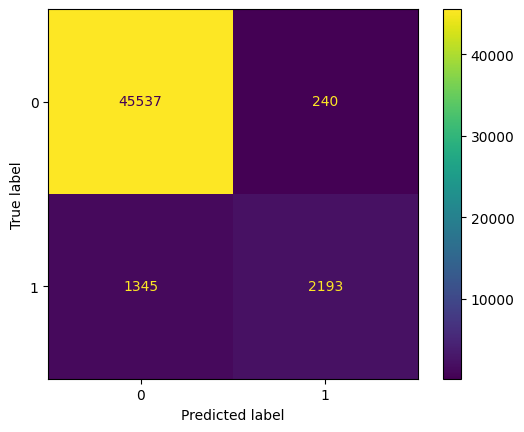

In [91]:
predicted_probability = model_filtro2.predict(X_test.squeeze())

y_p = []
for p in predicted_probability:
    if p> 0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_p = np.array(y_p)

result = confusion_matrix(y_test.squeeze(), y_p)
disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0, 1])
disp.plot()

## Balancing classes

In [43]:
model_1_balanced = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(labels_NSV), y=labels_NSV)
class_weights = dict(enumerate(class_weights_array))

model_1_balanced.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5),'precision', 'recall'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_1_balanced.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), class_weight= class_weights, callbacks= [early_stopping])

loss, f1score, precision, recall = model_1_balanced.evaluate(X_test, y_test)

Epoch 1/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - f1_score: 0.2700 - loss: 0.4463 - precision: 0.1600 - recall: 0.8846 - val_f1_score: 0.2701 - val_loss: 0.6164 - val_precision: 0.1574 - val_recall: 0.9517
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_score: 0.3046 - loss: 0.3208 - precision: 0.1822 - recall: 0.9293 - val_f1_score: 0.3172 - val_loss: 0.4263 - val_precision: 0.1918 - val_recall: 0.9168
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_score: 0.3028 - loss: 0.3096 - precision: 0.1807 - recall: 0.9338 - val_f1_score: 0.3059 - val_loss: 0.4864 - val_precision: 0.1830 - val_recall: 0.9303
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_score: 0.3128 - loss: 0.3009 - precision: 0.1877 - recall: 0.9380 - val_f1_score: 0.2922 - val_loss: 0.4561 - val_precision: 0.1728 - val_recall: 0.9454
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - f1_score: 0.3120 - loss: 0.2940 - precision: 0.1869 - recall: 0.9443 - val_f1_score: 0.2967

## Regularize

### L1 regularization

In [34]:
model_reg = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu', kernel_regularizer = regularizers.L1(0.0001)),
    Dense(128, activation='relu', kernel_regularizer = regularizers.L1(0.0001)),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_reg.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), 'precision', 'recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_reg.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

loss, f1score, precision, recall = model_reg.evaluate(X_test, y_test)

Epoch 1/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - f1_score: 0.1058 - loss: 0.5355 - precision: 0.4855 - recall: 0.0620 - val_f1_score: 0.5360 - val_loss: 0.1909 - val_precision: 0.8069 - val_recall: 0.4013
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5494 - loss: 0.1871 - precision: 0.7448 - recall: 0.4353 - val_f1_score: 0.5829 - val_loss: 0.1708 - val_precision: 0.7701 - val_recall: 0.4690
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.5716 - loss: 0.1730 - precision: 0.7570 - recall: 0.4594 - val_f1_score: 0.5944 - val_loss: 0.1656 - val_precision: 0.7517 - val_recall: 0.4916
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5896 - loss: 0.1661 - precision: 0.7730 - recall: 0.4766 - val_f1_score: 0.6115 - val_loss: 0.1610 - val_precision: 0.7430 - val_recall: 0.5196
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5930 - loss: 0.1633 - precision: 0.7677 - recall: 0.4831 - val_f1_score: 0.6023

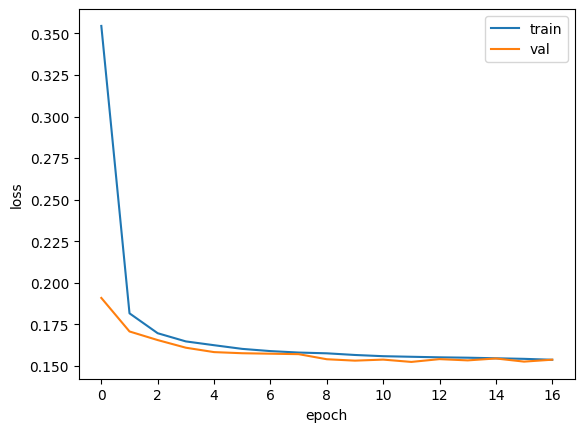

In [35]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('l1reg.png')
plt.show()

### With a dropout rate (i.e. Baseline model)

In [9]:
model_reg2 = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dropout(rate= 0.2), 
    Dense(128, activation='relu'),
    Dropout(rate= 0.2),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_reg2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), Precision(), Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_reg2.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

loss, f1score, precision, recall = model_reg2.evaluate(X_test, y_test)

Epoch 1/40
  90/6163 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - f1_score: 0.0682 - loss: 0.5164 - precision: 0.1085 - recall: 0.0800

I0000 00:00:1721382667.786715     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - f1_score: 0.1960 - loss: 0.2310 - precision: 0.5007 - recall: 0.1266 - val_f1_score: 0.5892 - val_loss: 0.1532 - val_precision: 0.7781 - val_recall: 0.4741
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5673 - loss: 0.1557 - precision: 0.7759 - recall: 0.4475 - val_f1_score: 0.5836 - val_loss: 0.1444 - val_precision: 0.8396 - val_recall: 0.4473
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.5741 - loss: 0.1497 - precision: 0.7961 - recall: 0.4490 - val_f1_score: 0.6109 - val_loss: 0.1423 - val_precision: 0.7961 - val_recall: 0.4956
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - f1_score: 0.5874 - loss: 0.1452 - precision: 0.8117 - recall: 0.4604 - val_f1_score: 0.6285 - val_loss: 0.1405 - val_precision: 0.7758 - val_recall: 0.5282
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - f1_score: 0.5976 - loss: 0.1422 - precision: 0.8147 - recall: 0.4719 - val_f1_score: 0.6220 - val_loss

1541/1541 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<Figure size 800x600 with 0 Axes>

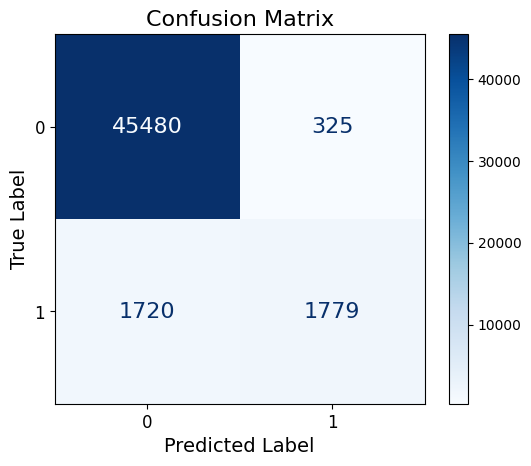

In [13]:
predicted_probability = model_reg2.predict(X_test.squeeze())

y_p = np.where(predicted_probability > 0.5, 1, 0)
result = confusion_matrix(y_test.squeeze(), y_p)

disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0, 1])

plt.figure(figsize=(8, 6)) 
disp.plot(cmap='Blues')  
for text in disp.ax_.texts:
    text.set_fontsize(16) 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

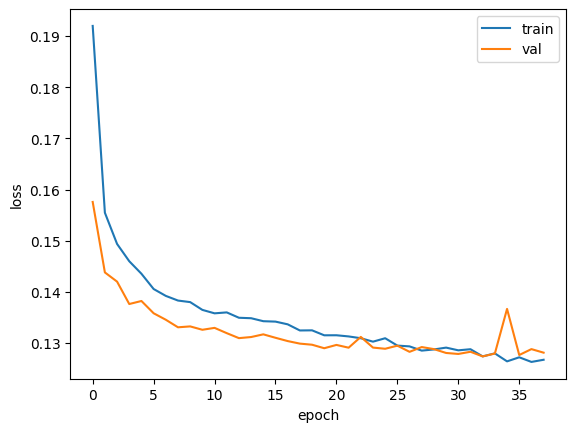

In [30]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('dropout.png')
plt.show()

Here we can see that we dropped a little the performances on the train set, but we avoid successfully overfitting.

# (1b. More layers)

In [11]:
model_ML = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dropout(rate= 0.2), 
    Dense(128, activation='relu'),
    Dropout(rate= 0.2),
    Dense(64, activation='relu'),
    Dropout(rate= 0.2),
    Dense(32, activation='relu'),
    Dropout(rate= 0.15),
    Dense(16, activation='relu'),
    Dropout(rate= 0.15),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_ML.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), 'precision', 'recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_ML.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

loss, f1score, precision, recall = model_ML.evaluate(X_test, y_test)

Epoch 1/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - f1_score: 0.0030 - loss: 0.2360 - precision: 0.1397 - recall: 0.0017 - val_f1_score: 0.6036 - val_loss: 0.1610 - val_precision: 0.7381 - val_recall: 0.5106
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - f1_score: 0.5065 - loss: 0.1645 - precision: 0.7332 - recall: 0.3870 - val_f1_score: 0.6106 - val_loss: 0.1426 - val_precision: 0.7997 - val_recall: 0.4939
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - f1_score: 0.5748 - loss: 0.1517 - precision: 0.7835 - recall: 0.4540 - val_f1_score: 0.6116 - val_loss: 0.1405 - val_precision: 0.8089 - val_recall: 0.4916
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - f1_score: 0.5810 - loss: 0.1453 - precision: 0.8025 - recall: 0.4553 - val_f1_score: 0.6131 - val_loss: 0.1387 - val_precision: 0.8122 - val_recall: 0.4925
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - f1_score: 0.5905 - loss: 0.1423 - precision: 0.8144 - recall: 0.4633 - val_f1_score: 0.6106

# 2. More More Layers (i.e. Deeper NN)

In [12]:
model_MML = Sequential([

    Input(shape = (window_size, 1)),
    Flatten(),
    Dense(window_size, activation='relu'),
    Dropout(rate= 0.25),
    Dense(256, activation='relu'),
    Dropout(rate= 0.15),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_MML.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), 'precision', 'recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_MML.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

loss, f1score, precision, recall = model_MML.evaluate(X_test, y_test)
print(f"Test f1score: {f1score * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")

Epoch 1/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - f1_score: 0.3366 - loss: 0.2084 - precision: 0.6308 - recall: 0.2379 - val_f1_score: 0.6002 - val_loss: 0.1445 - val_precision: 0.7871 - val_recall: 0.4850
Epoch 2/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - f1_score: 0.5831 - loss: 0.1460 - precision: 0.7913 - recall: 0.4618 - val_f1_score: 0.6190 - val_loss: 0.1366 - val_precision: 0.7973 - val_recall: 0.5059
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.5908 - loss: 0.1411 - precision: 0.7996 - recall: 0.4686 - val_f1_score: 0.6342 - val_loss: 0.1325 - val_precision: 0.7956 - val_recall: 0.5273
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.6027 - loss: 0.1397 - precision: 0.8106 - recall: 0.4798 - val_f1_score: 0.6277 - val_loss: 0.1323 - val_precision: 0.7901 - val_recall: 0.5207
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - f1_score: 0.6095 - loss: 0.1366 - precision: 0.8078 - recall: 0.4894 - val_f1_score: 0.6319

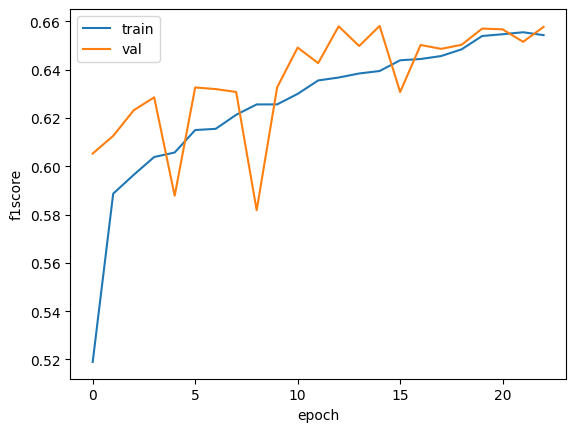

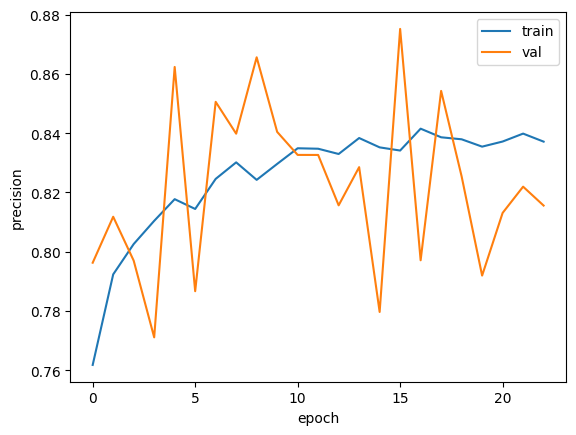

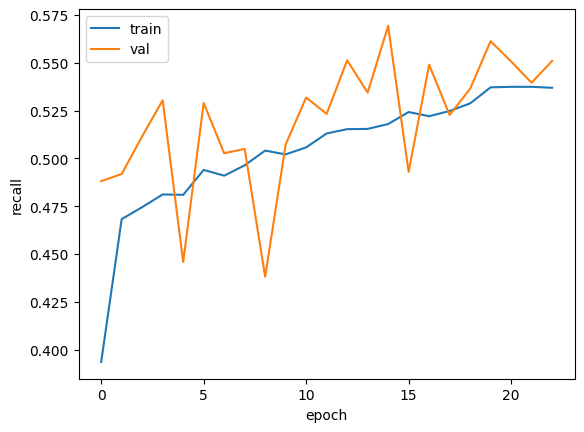

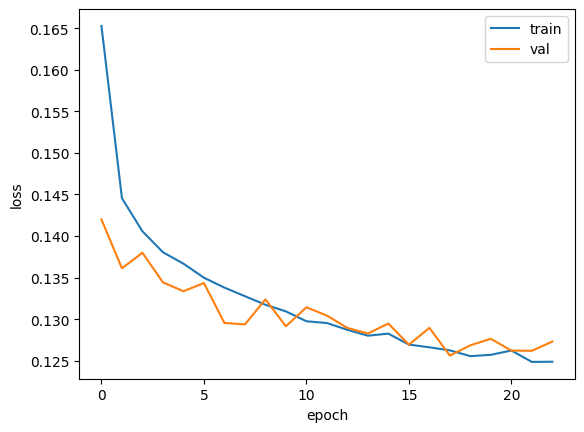

In [56]:
plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('epoch')
plt.ylabel('f1score')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

# 3. Convolutional Neural Network (CNN)

In [36]:
model_CNN = Sequential([

    Input(shape=(window_size,1)),
    Conv1D(window_size,kernel_size=15, activation='relu'),
    MaxPooling1D(pool_size= 3),
    Conv1D(int(window_size/3),kernel_size=11, activation='relu'),
    MaxPooling1D(pool_size= 2),
    Flatten(),  
    Dropout(rate= 0.3),
    Dense(45, activation='relu'),
    Dropout(rate= 0.3),
    Dense(32, activation='relu'),
    Dense(1, activation= 'sigmoid')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), 'precision', 'recall'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_CNN.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks= [early_stopping])

loss, f1score, precision, recall = model_CNN.evaluate(X_test, y_test)

Epoch 1/40
  28/6163 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - f1_score: 0.0000e+00 - loss: 0.5051 - precision: 0.0000e+00 - recall: 0.0000e+00

W0000 00:00:1721385832.340347     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.4153 - loss: 0.1818 - precision: 0.7187 - recall: 0.3001

W0000 00:00:1721385859.198524     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721385860.141471     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - f1_score: 0.4153 - loss: 0.1818 - precision: 0.7187 - recall: 0.3001 - val_f1_score: 0.6202 - val_loss: 0.1353 - val_precision: 0.7937 - val_recall: 0.5090
Epoch 2/40
  19/6163 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - f1_score: 0.4201 - loss: 0.1578 - precision: 0.6879 - recall: 0.3028            

W0000 00:00:1721385863.606308     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - f1_score: 0.5812 - loss: 0.1437 - precision: 0.7870 - recall: 0.4610 - val_f1_score: 0.5883 - val_loss: 0.1357 - val_precision: 0.8656 - val_recall: 0.4456
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - f1_score: 0.6087 - loss: 0.1368 - precision: 0.8045 - recall: 0.4898 - val_f1_score: 0.6383 - val_loss: 0.1396 - val_precision: 0.8026 - val_recall: 0.5299
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - f1_score: 0.6232 - loss: 0.1351 - precision: 0.8042 - recall: 0.5088 - val_f1_score: 0.6485 - val_loss: 0.1282 - val_precision: 0.8159 - val_recall: 0.5382
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - f1_score: 0.6306 - loss: 0.1336 - precision: 0.8130 - recall: 0.5150 - val_f1_score: 0.6432 - val_loss: 0.1263 - val_precision: 0.8224 - val_recall: 0.5282
Epoch 6/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - f1_score: 0.6291 - loss: 0.1305 - precision: 0.8077 - recall: 0.5152 - val_f1_score: 0.6392 - val_loss

## Confusion matrix

 109/1541 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

W0000 00:00:1721386470.276320     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1541/1541 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1721386472.717953     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<Figure size 800x600 with 0 Axes>

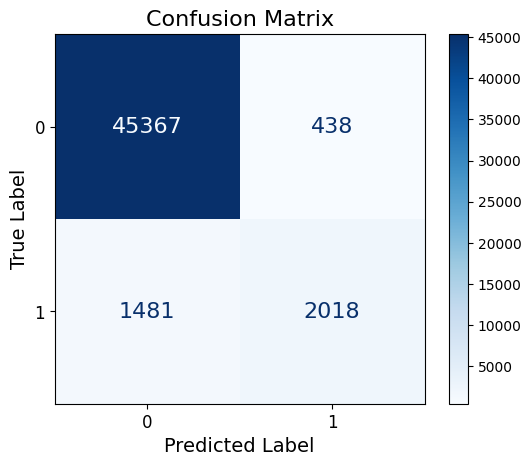

In [37]:
predicted_probability = model_CNN.predict(X_test.squeeze())

y_p = np.where(predicted_probability > 0.5, 1, 0)

result = confusion_matrix(y_test.squeeze(), y_p)

disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0, 1])

plt.figure(figsize=(8, 6))  
disp.plot(cmap='Blues')  
for text in disp.ax_.texts:
    text.set_fontsize(16) 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('cm1.png')
plt.show()

## Confusion matrix normalized on true values

1541/1541 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<Figure size 800x600 with 0 Axes>

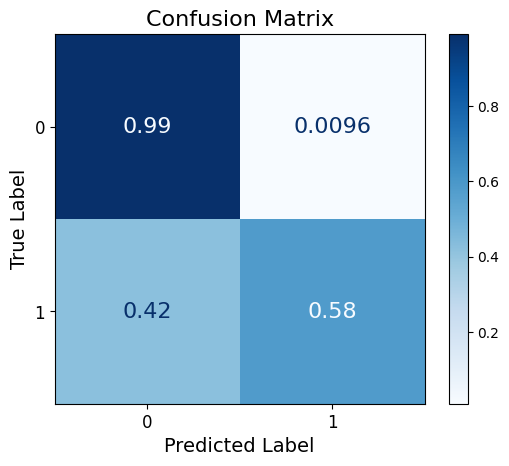

In [38]:
predicted_probability = model_CNN.predict(X_test.squeeze())

y_p = np.where(predicted_probability > 0.5, 1, 0)

result = confusion_matrix(y_test.squeeze(), y_p, normalize= 'true')

disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0, 1])

plt.figure(figsize=(8, 6))  
disp.plot(cmap='Blues')  
for text in disp.ax_.texts:
    text.set_fontsize(16) 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('cm2.png')
plt.show()

## Confusion matrix normalized on predicted values

1541/1541 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<Figure size 800x600 with 0 Axes>

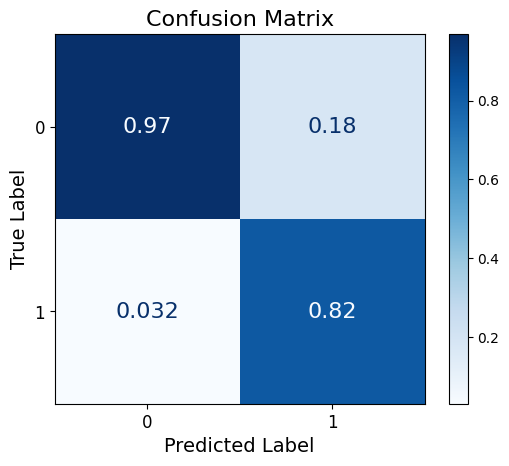

In [39]:
predicted_probability = model_CNN.predict(X_test.squeeze())

y_p = np.where(predicted_probability > 0.5, 1, 0)

result = confusion_matrix(y_test.squeeze(), y_p, normalize= 'pred')

disp = ConfusionMatrixDisplay(confusion_matrix=result,
                              display_labels=[0, 1])

plt.figure(figsize=(8, 6))  
disp.plot(cmap='Blues')  
for text in disp.ax_.texts:
    text.set_fontsize(16) 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('cm3.png')
plt.show()

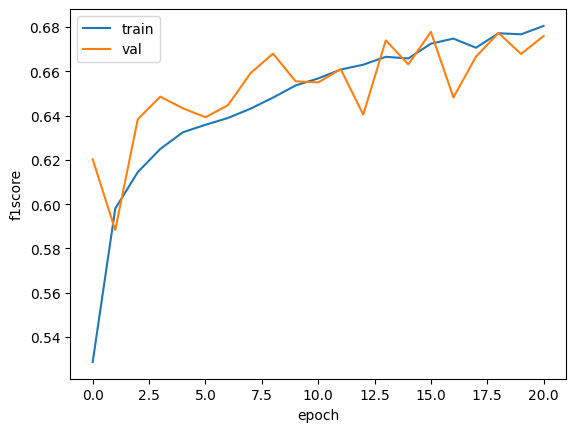

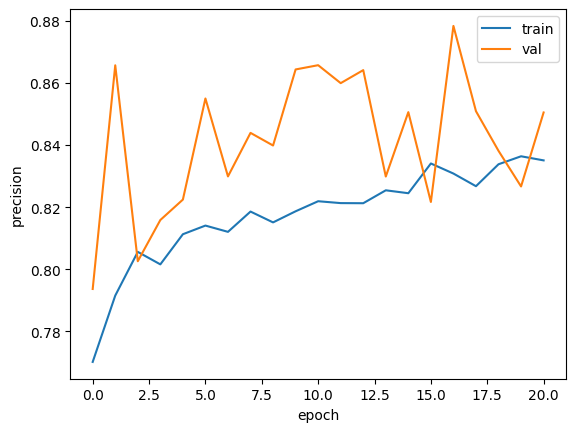

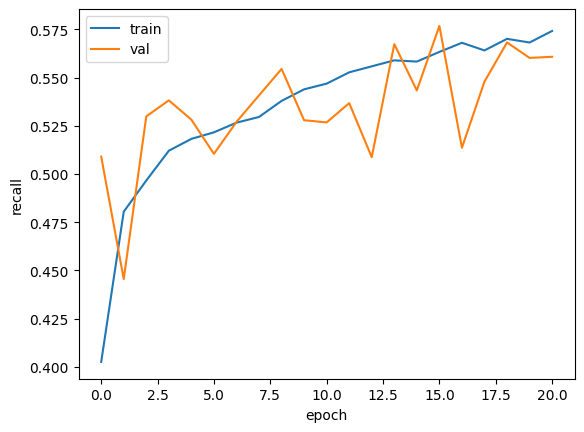

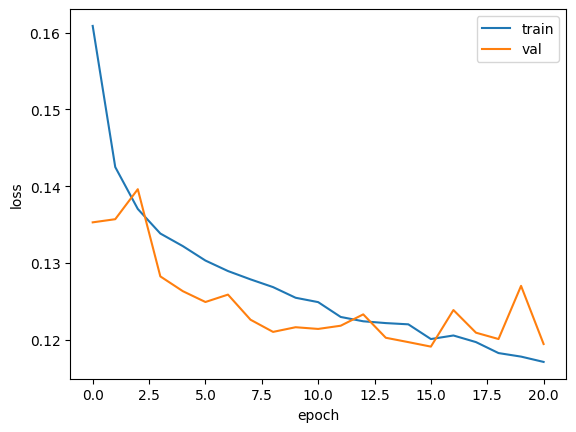

In [40]:
plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('epoch')
plt.ylabel('f1score')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

# (4.LSTM)

In [ ]:
model_LSTM = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(0.0005)

# Compilazione del modello
model_LSTM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold= 0.5), 'precision', 'recall'])

# Addestramento del modello
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_LSTM.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test),  callbacks= [early_stopping])

# Valutazione del modello
loss, f1score, precision, recall = model_LSTM.evaluate(X_test, y_test)

In [ ]:
plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('epoch')
plt.ylabel('f1_score')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.xlabel('epoch')
plt.ylabel('recall')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()

# Multi-label classification

## Mapping correctly the labels

In [42]:
def map_labels_pro(label):
    if label == 'N':
        return 0
    if label == 'V':
        return 1
    if label == 'S':
        return 2

labels_mapped = np.array([map_labels_pro(label) for label in labels_NSV])

## Scale and train-test split

In [43]:
scaler = StandardScaler()
segments = scaler.fit_transform(segments_NSV)

X_train, X_test, y_train, y_test = train_test_split(segments, labels_mapped, test_size=0.2, random_state=42)

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [44]:
model_CNN3 = Sequential([

    Input(shape=(window_size,1)),
    Conv1D(window_size,kernel_size=15, activation='relu'),
    MaxPooling1D(pool_size= 3),
    Conv1D(int(window_size/3),kernel_size=11, activation='relu'),
    MaxPooling1D(pool_size= 2),
    Flatten(),  
    Dropout(rate= 0.3),
    Dense(45, activation='relu'),
    Dropout(rate= 0.3),
    Dense(32, activation='relu'),
    Dense(3, activation= 'softmax')
    
])

optimizer = tf.keras.optimizers.Adam(0.0005)

model_CNN3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_CNN3.fit(X_train, y_train_one_hot, epochs=40, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks= [early_stopping])

loss, accuracy = model_CNN3.evaluate(X_test, y_test_one_hot)


Epoch 1/40
  28/6163 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8854 - loss: 0.7592 

W0000 00:00:1721386690.168126     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9314 - loss: 0.2468

W0000 00:00:1721386718.615665     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721386719.373977     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9314 - loss: 0.2468 - val_accuracy: 0.9441 - val_loss: 0.1838
Epoch 2/40
  19/6163 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9295 - loss: 0.2346 

W0000 00:00:1721386722.525310     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9409 - loss: 0.1923 - val_accuracy: 0.9472 - val_loss: 0.1734
Epoch 3/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9449 - loss: 0.1802 - val_accuracy: 0.9485 - val_loss: 0.1678
Epoch 4/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9464 - loss: 0.1756 - val_accuracy: 0.9486 - val_loss: 0.1705
Epoch 5/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9479 - loss: 0.1714 - val_accuracy: 0.9503 - val_loss: 0.1637
Epoch 6/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9485 - loss: 0.1690 - val_accuracy: 0.9513 - val_loss: 0.1617
Epoch 7/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9490 - loss: 0.1693 - val_accuracy: 0.9504 - val_loss: 0.1629
Epoch 8/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9484 - loss: 0.1695 - val_accuracy: 0.9509 - val_loss: 0.1609
Epoch 9/40
6163/6163 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9491 - loss: 0.1665 - val

## Confusion matrix

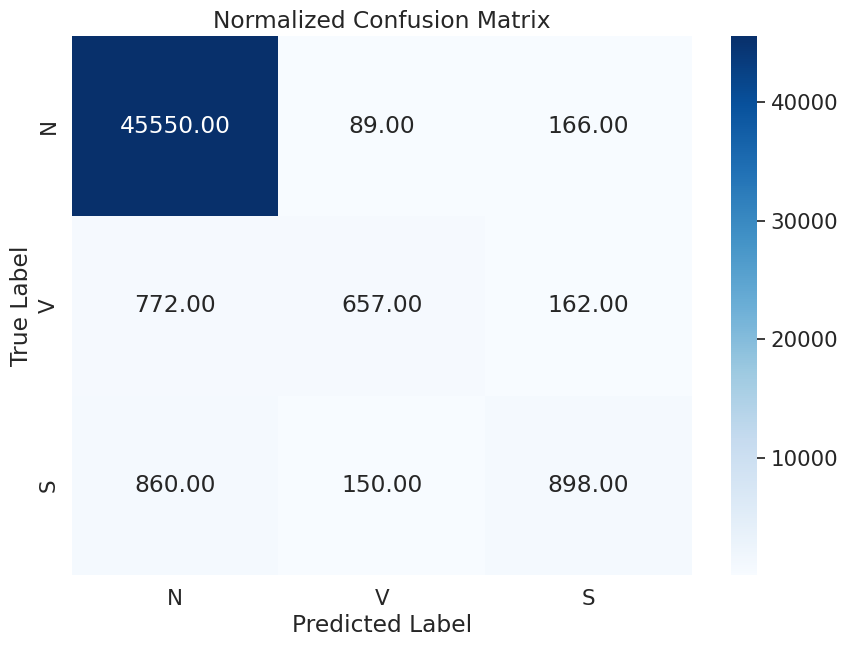

In [47]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['N', 'V', 'S'], yticklabels=['N', 'V', 'S'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

## Confusion matrix normalized on true values

 113/1541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

W0000 00:00:1721387715.918947     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1541/1541 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1721387718.312413     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


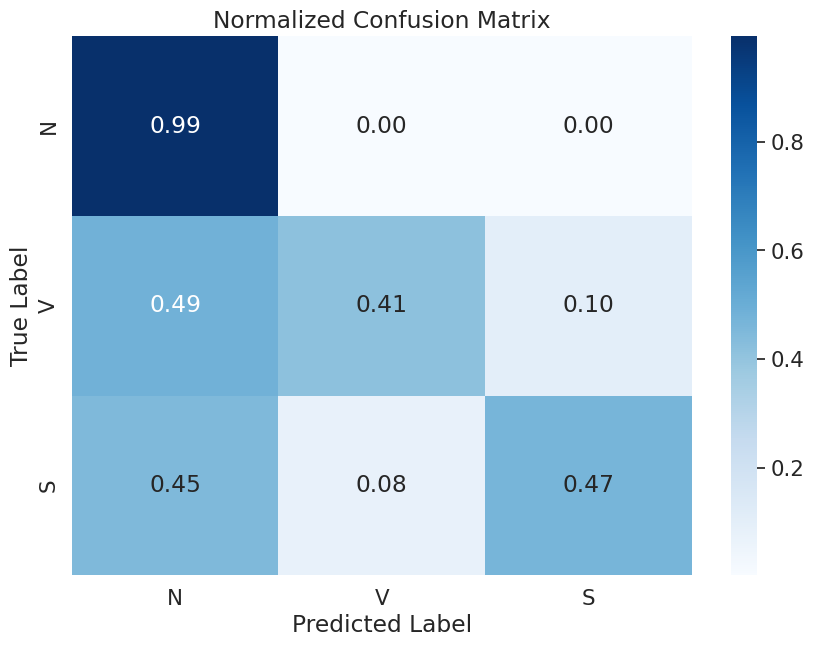

In [45]:
y_pred = model_CNN3.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['N', 'V', 'S'], yticklabels=['N', 'V', 'S'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.savefig('confusion_matrix_rescaled_true.png')
plt.show()

## Confusion matrix normalized on predicted values

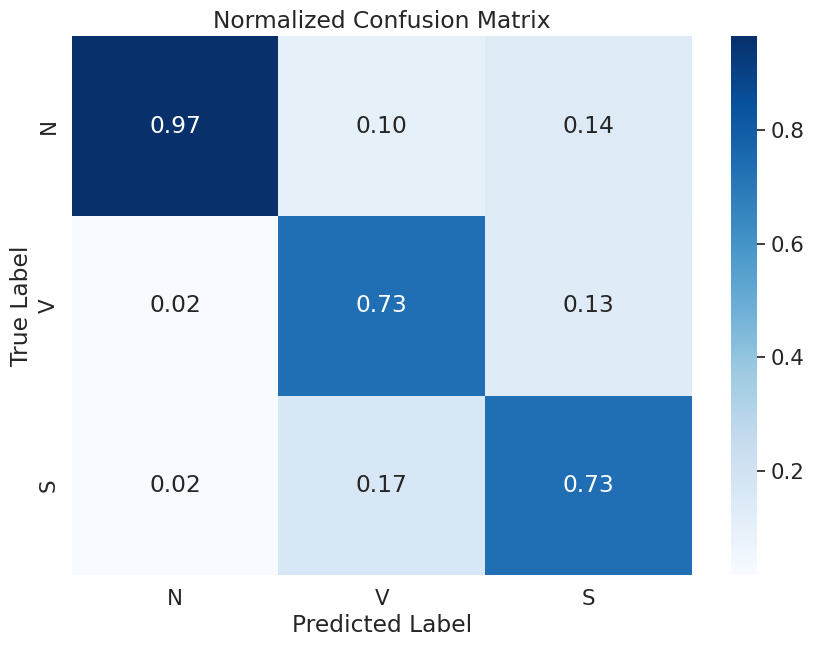

In [46]:
cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['N', 'V', 'S'], yticklabels=['N', 'V', 'S'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.savefig('confusion_matrix_rescaled_pred.png')
plt.show()

## Classification report

In [48]:
report = classification_report(y_test, y_pred_labels, target_names=['N', 'V', 'S'], output_dict= True)

In [49]:
print(classification_report(y_test, y_pred_labels, target_names=['N', 'V', 'S']))

              precision    recall  f1-score   support

           N       0.97      0.99      0.98     45805
           V       0.73      0.41      0.53      1591
           S       0.73      0.47      0.57      1908

    accuracy                           0.96     49304
   macro avg       0.81      0.63      0.69     49304
weighted avg       0.95      0.96      0.95     49304



In [50]:
df = pd.DataFrame(report).transpose()

latex_table = df.to_latex(index=True)
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
N & 0.965411 & 0.994433 & 0.979707 & 45805.000000 \\
V & 0.733259 & 0.412948 & 0.528347 & 1591.000000 \\
S & 0.732463 & 0.470650 & 0.573070 & 1908.000000 \\
accuracy & 0.955399 & 0.955399 & 0.955399 & 0.955399 \\
macro avg & 0.810378 & 0.626010 & 0.693708 & 49304.000000 \\
weighted avg & 0.948904 & 0.955399 & 0.949406 & 49304.000000 \\
\bottomrule
\end{tabular}



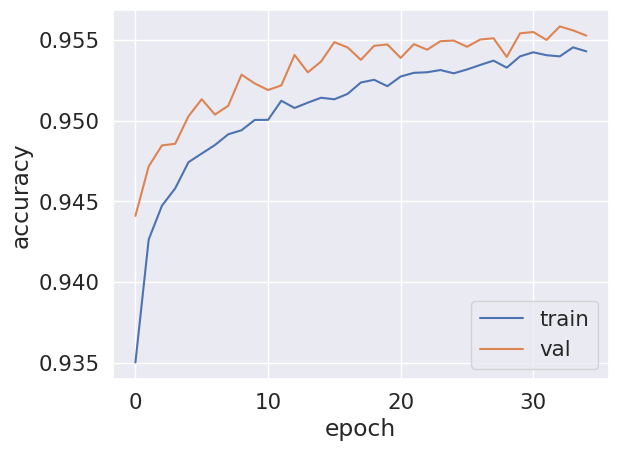

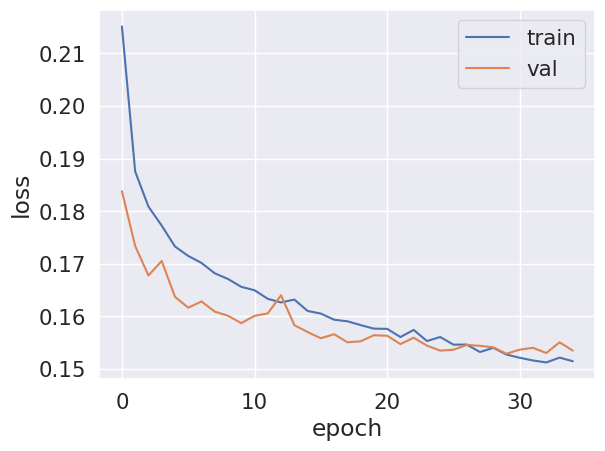

In [51]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])

plt.show()